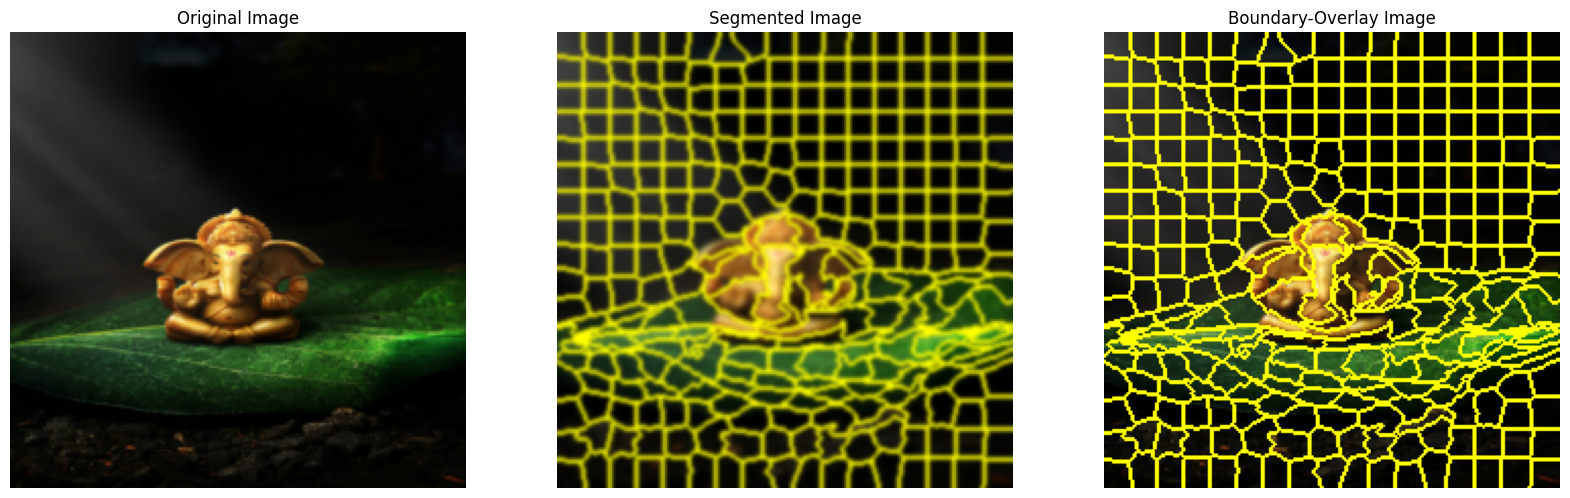

Adjusted Rand Index (ARI): 0.7934
Boundary F1 Score: 0.7942


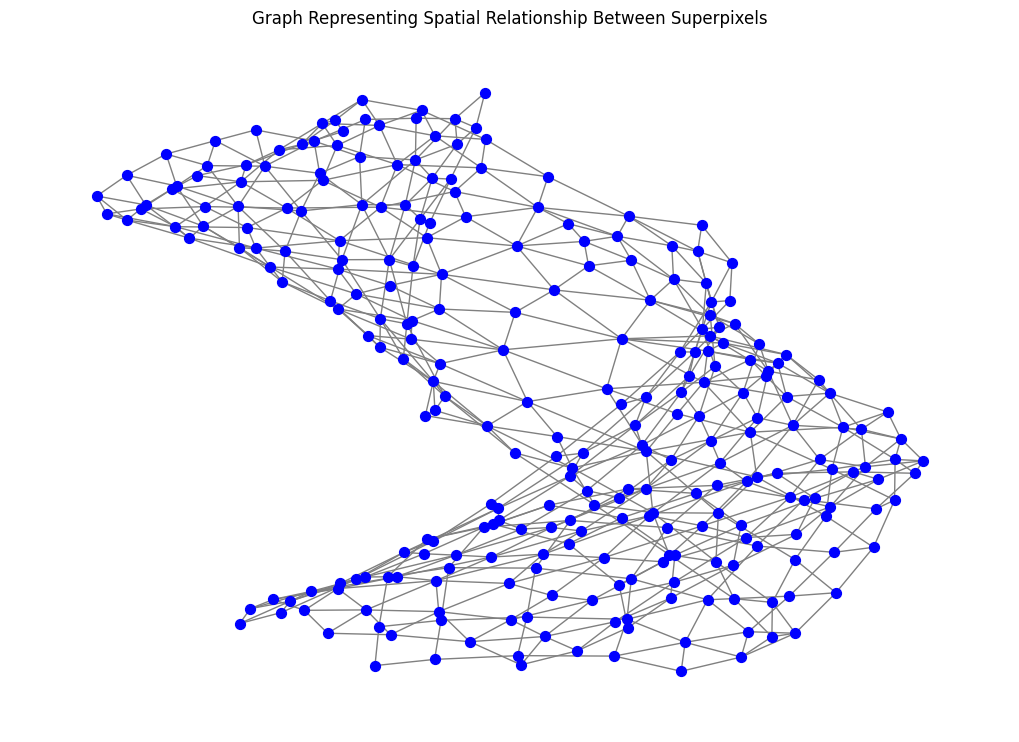

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from skimage import color
from skimage.filters import gaussian
from skimage.morphology import erosion, dilation, disk
from skimage.transform import resize
from skimage.metrics import adapted_rand_error
from sklearn.metrics import adjusted_rand_score
import networkx as nx

# Data Preprocessing
def preprocess_image(image):
    """Resize, denoise, and normalize the image."""
    image = resize(image, (224, 224, 3), anti_aliasing=True)
    image = np.stack([gaussian(image[..., i], sigma=1) for i in range(image.shape[-1])], axis=-1)
    image = image / np.max(image) if np.max(image) > 0 else image  # Normalize to the [0, 1] range
    return image

# Superpixel Generation (SLIC Algorithm)
def generate_superpixels(image, n_segments=500, compactness=10):
    """Generate superpixels using SLIC with dynamic parameters."""
    segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=1)
    return segments

# Optimized Hierarchical Merging
def hierarchical_merging(segments):
    """Perform optimized hierarchical merging based on texture similarity."""
    merged_segments = dilation(segments, disk(1))
    merged_segments = erosion(merged_segments, disk(1))
    return merged_segments

# Multi-scale Segmentation
def multi_scale_segmentation(image, segments):
    """Apply hierarchical merging and boundary smoothing."""
    merged_segments = hierarchical_merging(segments)
    boundaries = mark_boundaries(image, merged_segments)
    smoothed_boundaries = np.stack([gaussian(boundaries[..., i], sigma=1) for i in range(boundaries.shape[-1])], axis=-1)
    smoothed_boundaries = np.clip(smoothed_boundaries, 0, 1)  # Ensure values remain in range
    return smoothed_boundaries, merged_segments

# Enhanced Visualization with Boundary Overlay
def visualize_results(original_image, segmented_image, boundaries):
    """Display original, segmented, and boundary-overlaid images."""
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))

    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(segmented_image)
    ax[1].set_title('Segmented Image')
    ax[1].axis('off')

    ax[2].imshow(boundaries)
    ax[2].set_title('Boundary-Overlay Image')
    ax[2].axis('off')

    plt.show()

# Graph Representation of Superpixel Relationships
def plot_superpixel_graph(segments):
    """Plot a graph showing the spatial relationship between superpixels."""
    graph = nx.Graph()
    rows, cols = segments.shape

    # Add nodes for each superpixel
    unique_segments = np.unique(segments)
    for segment in unique_segments:
        graph.add_node(segment)

    # Add edges between neighboring superpixels
    for i in range(rows - 1):
        for j in range(cols - 1):
            current = segments[i, j]
            right = segments[i, j + 1]
            down = segments[i + 1, j]

            if current != right:
                graph.add_edge(current, right)
            if current != down:
                graph.add_edge(current, down)

    # Plot the graph
    pos = nx.spring_layout(graph, seed=42)  # Force-directed layout
    plt.figure(figsize=(10, 7))
    nx.draw(graph, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
    plt.title('Graph Representing Spatial Relationship Between Superpixels')
    plt.show()

# Segmentation Quality Evaluation
def evaluate_segmentation(original_image, segmented_image, ground_truth):
    """Evaluate segmentation using ARI and Boundary F1 Score."""

    # Convert images to grayscale if needed
    if len(original_image.shape) == 3:
        original_image = color.rgb2gray(original_image)
    if len(segmented_image.shape) == 3:
        segmented_image = color.rgb2gray(segmented_image)

    # Flatten arrays for metric calculations
    gt_flat = ground_truth.flatten()
    seg_flat = segmented_image.flatten()

    # Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(gt_flat, seg_flat)

    # Boundary F1 Score
    adapted_rand, _, _ = adapted_rand_error(ground_truth, segmented_image)
    boundary_f1 = 1 - adapted_rand  # F1 Score = 1 - Adapted Rand Error

    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Boundary F1 Score: {boundary_f1:.4f}")

# Main Function
def main():
    """Main pipeline for segmentation with enhanced visualization and interaction."""
    # Load and preprocess image
    image_path = '/content/god.jpeg'
    image = plt.imread(image_path)
    original_image = resize(image, (224, 224, 3), anti_aliasing=True)
    original_image = original_image / np.max(original_image) if np.max(original_image) > 0 else original_image
    processed_image = preprocess_image(image)

    # Superpixel Generation
    segments = generate_superpixels(processed_image, n_segments=300)

    # Multi-scale Segmentation
    segmented_image, merged_segments = multi_scale_segmentation(processed_image, segments)

    # Overlay boundaries
    boundary_overlay = mark_boundaries(original_image, merged_segments)

    # Display Enhanced Results
    visualize_results(original_image, segmented_image, boundary_overlay)

    # Evaluate Segmentation
    # Generate synthetic ground truth for evaluation
    ground_truth = generate_superpixels(original_image, n_segments=300, compactness=10)
    evaluate_segmentation(original_image, merged_segments, ground_truth)

    # Plot Superpixel Graph
    plot_superpixel_graph(segments)

if __name__ == '__main__':
    main()
